# Setup the directories

In [1]:
import os
base_dir = '/home/ayan/Documents/Computer Vision/Classification/Cat_Vs_Dog/cats_and_dogs_images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Data Preprocessing using ImageDataGenerator
ImageDataGenerator converts image files into batches of preprocessed tensors
Note: A Python generator is an object that acts as an iterator

In [2]:
import tensorflow as tf

#Rescale all pixel values between 0 - 255 to (1, 0)
train_idg = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')
test_idg = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255) #Validation images are not augmented

train_gen = train_idg.flow_from_directory(
    train_dir,
    target_size = (150, 150),       #resize images to (150, 150)
    batch_size = 32,                #32samples per batch i.e. shape = (32, 150, 150, 3)
    class_mode = 'binary'           #since this is a binary classification problem
)

valid_gen = test_idg.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Build a small ConvNet model
This is the most time consuming section.
I noticed that I am getting a better training accuracy using filter size = 5 and strides = 2 compared to MaxPooling

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

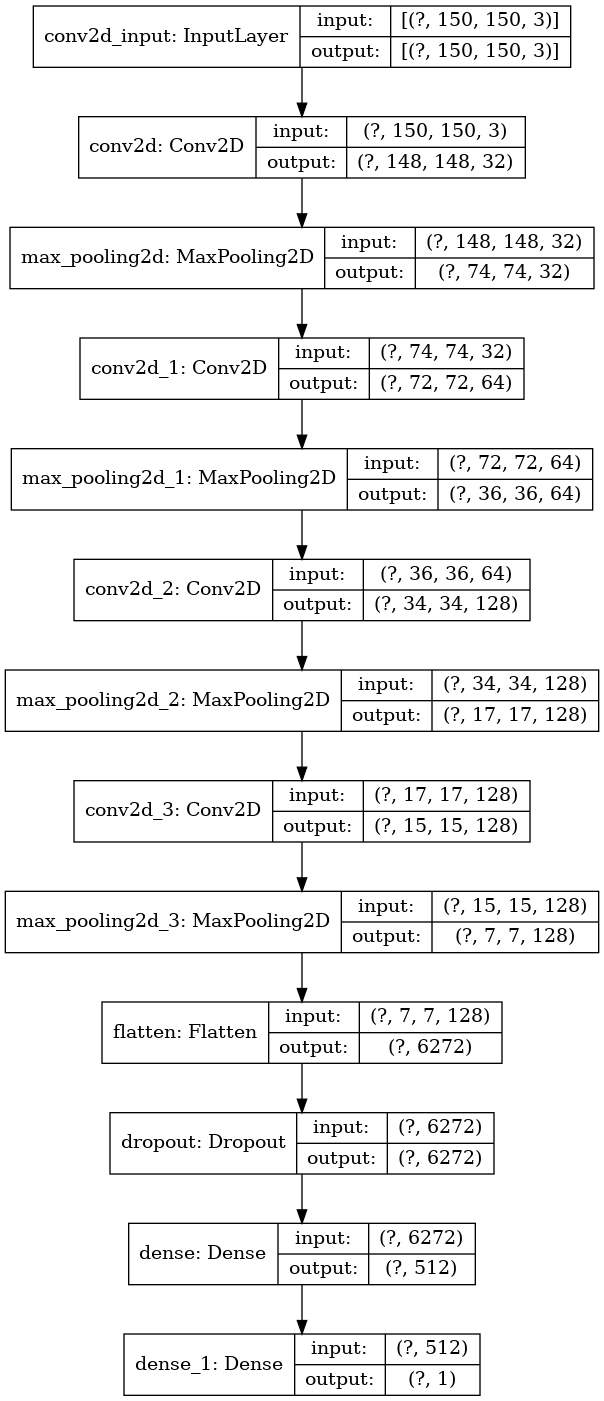

In [3]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu',
                input_shape = (150, 150, 3))) #channel last; num of params = (32 * ((3 * 3 * 3) + 1)) = 896
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

tf.keras.utils.plot_model(model, show_shapes = True, to_file = 'data-aug_convnet.png')

# Setup & configure optimizers

In [4]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
             loss = tf.keras.losses.binary_crossentropy,
             metrics = [tf.keras.metrics.binary_accuracy])

# Keras callback
Since I am running the training for a significant number of epochs hence it would be a good idea to implement callback to keep an eye on the training metrics

In [5]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'binary_accuracy'
        , patience = 10
    ,),
    tf.keras.callbacks.ModelCheckpoint(
        filepath = 'cat_vs_dog_2.h5'
        , monitor = 'val_loss'
        , save_best_only = True
    ,),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_loss'
        , factor = 0.1
        , patience = 10
        ,
    )
]

# Use batch generator
'steps_per_epoch' is for telling the fit_generator that it needs to run mentioned number of gradient descent steps before drawing the next epoch batch

'validation_steps' tells the process about number of batches to draw from the validation generator

In [6]:
history = model.fit(
    train_gen,
    steps_per_epoch = 100,
    epochs = 100,
    #callbacks = callbacks_list,  #Letting it run its full course
    validation_data = valid_gen,
    validation_steps = 50)

model.save('cat_vs_dog_2.h5')

Epoch 1/100
100/100 [==============================] - 13s 126ms/step - loss: 0.6897 - binary_accuracy: 0.5302 - val_loss: 0.6716 - val_binary_accuracy: 0.5590
Epoch 2/100
100/100 [==============================] - 12s 120ms/step - loss: 0.6688 - binary_accuracy: 0.5868 - val_loss: 0.6541 - val_binary_accuracy: 0.6057
Epoch 3/100
100/100 [==============================] - 12s 120ms/step - loss: 0.6482 - binary_accuracy: 0.6146 - val_loss: 0.6651 - val_binary_accuracy: 0.5774
Epoch 4/100
100/100 [==============================] - 12s 120ms/step - loss: 0.6237 - binary_accuracy: 0.6427 - val_loss: 0.6257 - val_binary_accuracy: 0.6327
Epoch 5/100
100/100 [==============================] - 12s 122ms/step - loss: 0.6163 - binary_accuracy: 0.6542 - val_loss: 0.6047 - val_binary_accuracy: 0.6459
Epoch 6/100
100/100 [==============================] - 12s 121ms/step - loss: 0.5981 - binary_accuracy: 0.6749 - val_loss: 0.5934 - val_binary_accuracy: 0.6727
Epoch 7/100
100/100 [===================

Epoch 52/100
100/100 [==============================] - 12s 120ms/step - loss: 0.4213 - binary_accuracy: 0.8008 - val_loss: 0.5141 - val_binary_accuracy: 0.7646
Epoch 53/100
100/100 [==============================] - 12s 120ms/step - loss: 0.4241 - binary_accuracy: 0.8043 - val_loss: 0.4461 - val_binary_accuracy: 0.7938
Epoch 54/100
100/100 [==============================] - 12s 120ms/step - loss: 0.4204 - binary_accuracy: 0.7990 - val_loss: 0.4516 - val_binary_accuracy: 0.7893
Epoch 55/100
100/100 [==============================] - 12s 120ms/step - loss: 0.4311 - binary_accuracy: 0.7932 - val_loss: 0.4534 - val_binary_accuracy: 0.8014
Epoch 56/100
100/100 [==============================] - 12s 121ms/step - loss: 0.4227 - binary_accuracy: 0.8034 - val_loss: 0.4601 - val_binary_accuracy: 0.7764
Epoch 57/100
100/100 [==============================] - 12s 121ms/step - loss: 0.4247 - binary_accuracy: 0.8046 - val_loss: 0.4303 - val_binary_accuracy: 0.7976
Epoch 58/100
100/100 [============

# Display training vs validation 

In [7]:
def smoothening(points, factor = 0.8):
    smooth_points = []
    for point in points:
        if smooth_points:
            previous = smooth_points[-1]
            smooth_points.append(previous * factor + point * (1 - factor))
        else:
            smooth_points.append(point)
    return smooth_points

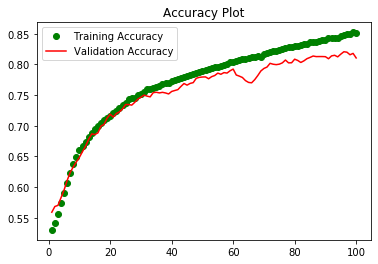

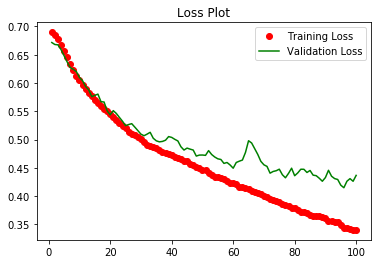

In [8]:
import matplotlib.pyplot as plt
train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, smoothening(train_acc), 'go', label = 'Training Accuracy')
plt.plot(epochs, smoothening(val_acc), 'r', label = 'Validation Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.figure()
plt.plot(epochs, smoothening(train_loss), 'ro', label = 'Training Loss')
plt.plot(epochs, smoothening(val_loss), 'g', label = 'Validation Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()